In [75]:
###############
# Need to check if complex hamiltonians are supported
# Need plotting functionality for complex quantities

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import kwant

import tinyarray

import lmfit as lmf

import scipy.linalg as lin

from tqdm import tqdm
import pickle

from scipy import stats

import warnings

In [57]:
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])
tau_0 = tinyarray.array([[1, 0], [0, 1]])

def Lorentzian(eex, ee, gam):
    return (gam/np.pi)*(1/((eex-ee)**2 + gam**2))

def Fermi(eps, beta = 'inf'):
    if beta == 'inf':
        return int(eps<0)
    else:
        return 1/(1+np.exp(beta*eps))

In [58]:
Fibonacci_number = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657]
tau_approximant = [1, 2.0, 1.5, 1.6666666666666667, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876, 1.6180555555555556, 1.6180257510729614, 1.6180371352785146, 1.618032786885246, 1.618034447821682, 1.6180338134001253, 1.618034055727554, 1.6180339631667064, 1.6180339985218033, 1.618033985017358, 1.6180339901755971]

In [59]:
class Fibonacci_chains:
    def __init__(self):
        self.Fibonacci_cellar = {}
    
    def get_chain(self,n,j):
        N = Fibonacci_number[n]
        if j>=N:
            warnings.warn("phi greater than 2 pi. Using modulo 2 pi.")
            j = j%N
        try:
            chain = self.Fibonacci_cellar[(n,j)]
        except KeyError:

            tau = tau_approximant[n]
            phi = 2*np.pi*j/N
            chain = ["A" if np.sign(np.cos(2*np.pi*m*(1/tau) + phi) - np.cos(np.pi*(1/tau)))>=0 else "B" for m in range(N)]
            self.Fibonacci_cellar[(n,j)] = chain
        return chain

FCs = Fibonacci_chains()

In [60]:
class TBmodel:
    def __init__(self, LL, ts, us, vs):
        self.LL = LL
        self.a = 1
        self.ts, self.us, self.vs = ts, us, vs
        self.Delta = np.array([1]*self.LL)
        self.Pot = np.zeros(self.LL)

    def onsite(self, site, Delta, Pot):
        (x,y) = site.tag
        return (self.us[x]+Pot[x])*tau_z - self.vs[x]*Delta[x]*tau_x
    
    def hopping(self,site1,site2):
        (x2,y2) = site2.tag
        (x1,y1) = site1.tag
        return self.ts[x1]*tau_z
    
    def make_syst(self):
        self.syst = kwant.Builder()
        self.lat = kwant.lattice.square(self.a, norbs = 2)
        
        self.syst[(self.lat(x,0) for x in range(self.LL))] = self.onsite
        self.syst[((self.lat(x+1,0),self.lat(x,0)) for x in range(self.LL-1))] = self.hopping
        self.syst[((self.lat(0,0), self.lat(self.LL-1,0)))] = self.hopping
        
        self.fsyst = self.syst.finalized()
        return

    def solve(self,H):
        (evals, evecs) = lin.eigh(H)
    
        uvecs = evecs[::2]
        vvecs = evecs[1::2]
        
        return (evals[self.LL:],uvecs[:,self.LL:],vvecs[:,self.LL:])

    def iterate(self):
        def self_cons(H):
            (evals, uvecs, vvecs) = self.solve(H)
            self.evals, self.uvecs, self.vvecs = (evals, uvecs, vvecs)
            
            Delta = np.zeros(self.LL, dtype = "complex128")
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                Delta += (1-2*Fermi(ee, beta = self.beta))*uvec*vvec.conjugate()
            
            occupancy = np.zeros(self.LL)
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                    occupancy += Fermi(ee, beta = self.beta)*2*np.abs(vvec)**2 + (1-Fermi(ee))*2*np.abs(uvec)**2
            
            Pot = 1/2*self.vs*occupancy
            Pot = Pot + 0.0001*np.ones(len(Pot))

            return (Delta, Pot)
        
        err_Delta = np.ones(1)
        cc = 0
        
        while any([err/Del>0.001 for err,Del in zip(err_Delta, self.Delta)]):
            H = self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
            newDelta, newPot = self_cons(H)
            err_Delta = np.abs(newDelta - self.Delta)
            
            cc += 1    
            self.Delta, self.Pot = newDelta, newPot
        
        print("Convergence took {} iterations".format(cc))
        
        self.H = H
        return self.Delta, self.Pot
        
    
    def get_DOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros(eex.shape)
        DOSv = np.zeros(eex.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += np.linalg.norm(uvec)**2*Lorentzian(eex,ee,gam) 
                DOSv += np.linalg.norm(vvec)**2*Lorentzian(eex,-ee,gam)
                
        self.DOS = (DOSu + DOSv)/self.LL
        return  self.DOS , eex
    
    def get_LDOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros((self.uvecs.shape[0],eex.shape[0]))
        DOSv = np.zeros(DOSu.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += (np.abs(uvec)**2)[:,np.newaxis]*Lorentzian(eex,ee,gam)
                DOSv += (np.abs(vvec)**2)[:,np.newaxis]*Lorentzian(eex,-ee,gam)      
            
        self.LDOS = (DOSu + DOSv)/self.LL
        return  self.LDOS,eex
    
    def get_ham(self,inds):
        if inds == 'full':
            return self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
        else:
            return self.fsyst.hamiltonian(*inds, params = dict(Delta = self.Delta, Pot = self.Pot))

In [61]:
class simple_ring(TBmodel):
    """
    Wrapper around TBmodel. Will generate a 1D tight-binding model with the parameters provided by chain.
    beta is the inversee temperature. use beta = "inf" for 0T.
    """
    def __init__(self, chain, beta = "inf"):
        self.chain = chain
        self.NN = chain["N"]
        self.beta = beta
        
        ts = np.array(chain["t"])
        us = np.array(chain["u"])
        vs = np.array(chain["v"])
        
        TBmodel.__init__(self, self.NN, ts, us, vs)

        self.make_syst()       

In [76]:
def chainFC(n = 3, t=-1, w = 0.1, phi = 0, u = 0, v = 0, wu = 0, wv = 0, PBC = True, phase = 0):
    """
    Generates the hoppings, the on-site potentials, and the BCS attraction terms for a chain of length Fibonacci_number[n]
    The ts modulate according to the Fibonacci word with tA-tB = w and phi = phi. On-site potential and BCS attraction 
    is drawn from the uniform distribution u±wu and v±wv respectively. PBC = True will use periodic boundary conditions, 
    while PBC=False will use open boundary conditions.
    """
    L = Fibonacci_number[n]
    tau = tau_approximant[n]
    FC = FCs.get_chain(n,phi)
    
    wa = 2*w/(1+tau)
    wb = tau*wa

    ts = [1-wa if letter =="A" else 1+wb for letter in FC]
    ts[-1] = ts[-1]*np.exp(1j*phase)
    
    if PBC:
        chain = {
            "N": L,
            "t": -np.array(ts),
            "u" : u - wu/2 + wu*np.random.rand(L),
            "v" : v - wv/2 + wv*np.random.rand(L)
        }
        
    else:
        chain = {
            "N": L+1,
            "t": -np.concatenate((np.zeros(1),np.array(ts))),
            "u" : u - wu/2 + wu*np.random.rand(L+1),
            "v" : v - wv/2 + wv*np.random.rand(L+1)
        }
        
    return chain


In [77]:
chain = chainFC(n = 12, v = -1.5, u = 0.75, w = 0.1,PBC = True, phase = np.pi/2)

In [78]:
Model = simple_ring(chain)

In [79]:
Model.iterate()

/

# with np.printoptions(precision=2, suppress=True):
#     print(Model.get_ham('full').real)

Convergence took 21 iterations


()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


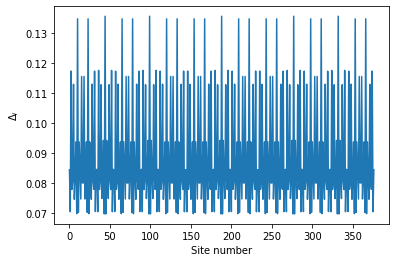

In [80]:
fig, ax = plt.subplots()

ax.plot(Model.Delta)
ax.set_xlabel("Site number")
ax.set_ylabel("$\\Delta_i$")

plt.savefig("Delta_temp_FC.png")

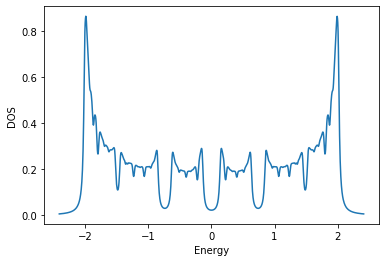

In [81]:
DOS, eex = Model.get_DOS(gam = 0.02)

fig, ax = plt.subplots()

ax.plot(eex, DOS)
ax.set_xlabel("Energy")
ax.set_ylabel("DOS")

plt.savefig("DOS_temp_FC.png")

## Get E as a function of phase

In [95]:
phases = np.linspace(-np.pi,np.pi,50)
ev_list = []
for phase in phases:
    chain = chainFC(n = 12, v = -1.5, u = 0.75, w = 0.1,PBC = True, phase = phase)
    Model = simple_ring(chain)
    Model.iterate()
    ev_list.append(Model.evals)
    

Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Converge

Text(0, 0.5, 'Energy')

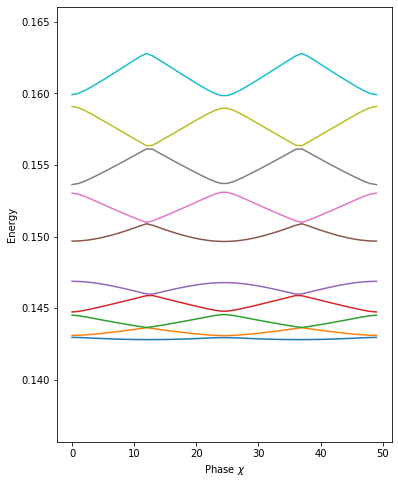

In [108]:
fig, ax = plt.subplots(figsize = (6,8))

ii = 10

ev_array = np.array(ev_list).T
[ax.plot(ev) for ev in ev_array[:ii]]
ax.set_ylim([0.95*np.min(ev_array[:ii]), 1.02*np.max(ev_array[:ii])])
ax.set_xlabel("Phase $\\chi$")
ax.set_ylabel("Energy")